#Detección de fraudes de transacciones financieras con DNN

En este notebook se propone hacer un modelo de clasificación  con DNN para clasificar con el mas alto grado de precisión fraudes de credito de un conjunto de datos financieros de Europa durante 2 dias en el mes de septiembre de 2013. Datos disponible en [Dataset fraudes](http://mlg.ulb.ac.be/ARTML)

In [0]:
!pip install watermark

In [0]:
!pip install imblearn

In [0]:
!pip install scikit-plot

In [0]:
#Paquetes de manipulación de datos
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

#keras y tensorflow
import tensorflow as tf
import keras

#Paquetes para balancear clases
import imblearn

#paquetes para visualizar datos
import matplotlib.pyplot as plt
import seaborn as sn
import scikitplot as skplt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0,4.0)

In [7]:
%reload_ext watermark
%watermark -a 'Christian Dayan Arcos Gordillo' --iversion

keras      2.3.1
pandas     1.0.3
imblearn   0.4.3
seaborn    0.10.0
scikitplot 0.3.7
sklearn    0.22.2.post1
numpy      1.18.2
tensorflow 2.2.0-rc2
Christian Dayan Arcos Gordillo


##Cargando el dataset

In [9]:
from google.colab import files
files.upload()

Saving creditcard.csv to creditcard.csv


In [0]:
df = pd.read_csv('creditcard.csv')

In [11]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##Análisis exploratorio

In [13]:
df.shape

(284807, 31)

In [14]:
#visualizar los tipos de datos de cada columna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [15]:
#Verificando si tiene datos nulos
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

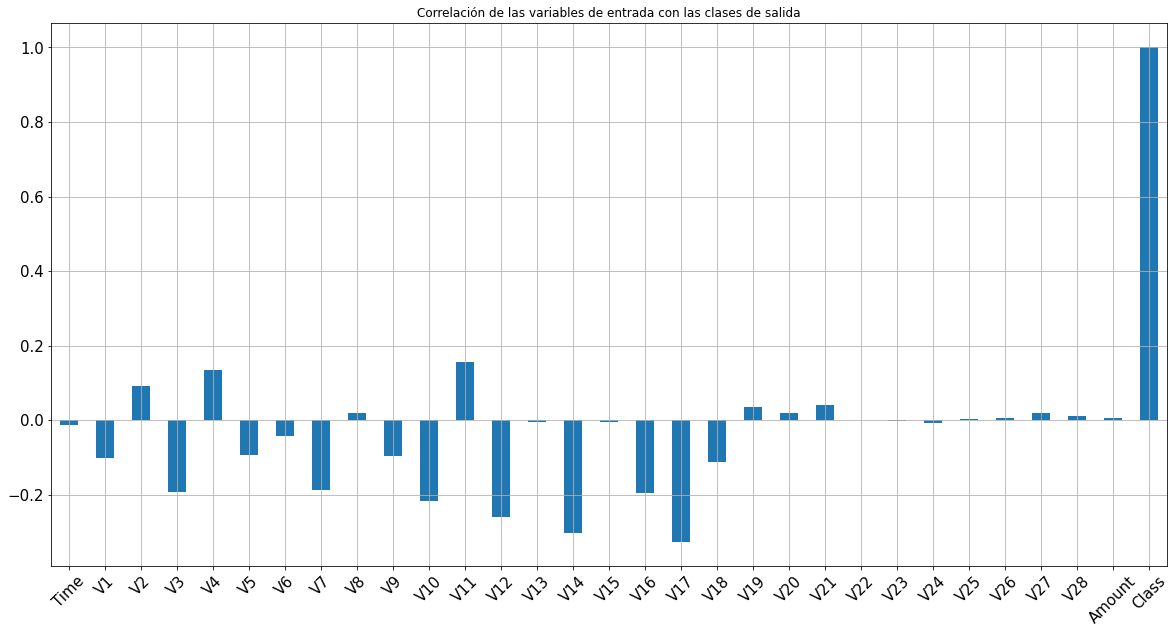

In [16]:
#observar la correlación de cada variable de entrada con la clase de salida
df.corrwith(df.Class).plot.bar(figsize = (20,10),
                               title = "Correlación de las variables de entrada con las clases de salida",
                               fontsize = 15,
                               rot = 45,
                               grid = True)

In [17]:
#Resumen de las estadisticas del dataset
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [0]:
#visualizar las distribuciones de cada variable
def histogramas(dataset, features, rows, cols):
  fig = plt.figure(figsize=(20,20))

  for i, feature in enumerate(features):
    ax = fig.add_subplot(rows,cols,i+1)
    dataset[feature].hist(bins=20,ax=ax,facecolor = 'midnightblue')
    ax.set_title(feature + " Distribución ", color = 'DarkRed')

  fig.tight_layout()
  plt.show()

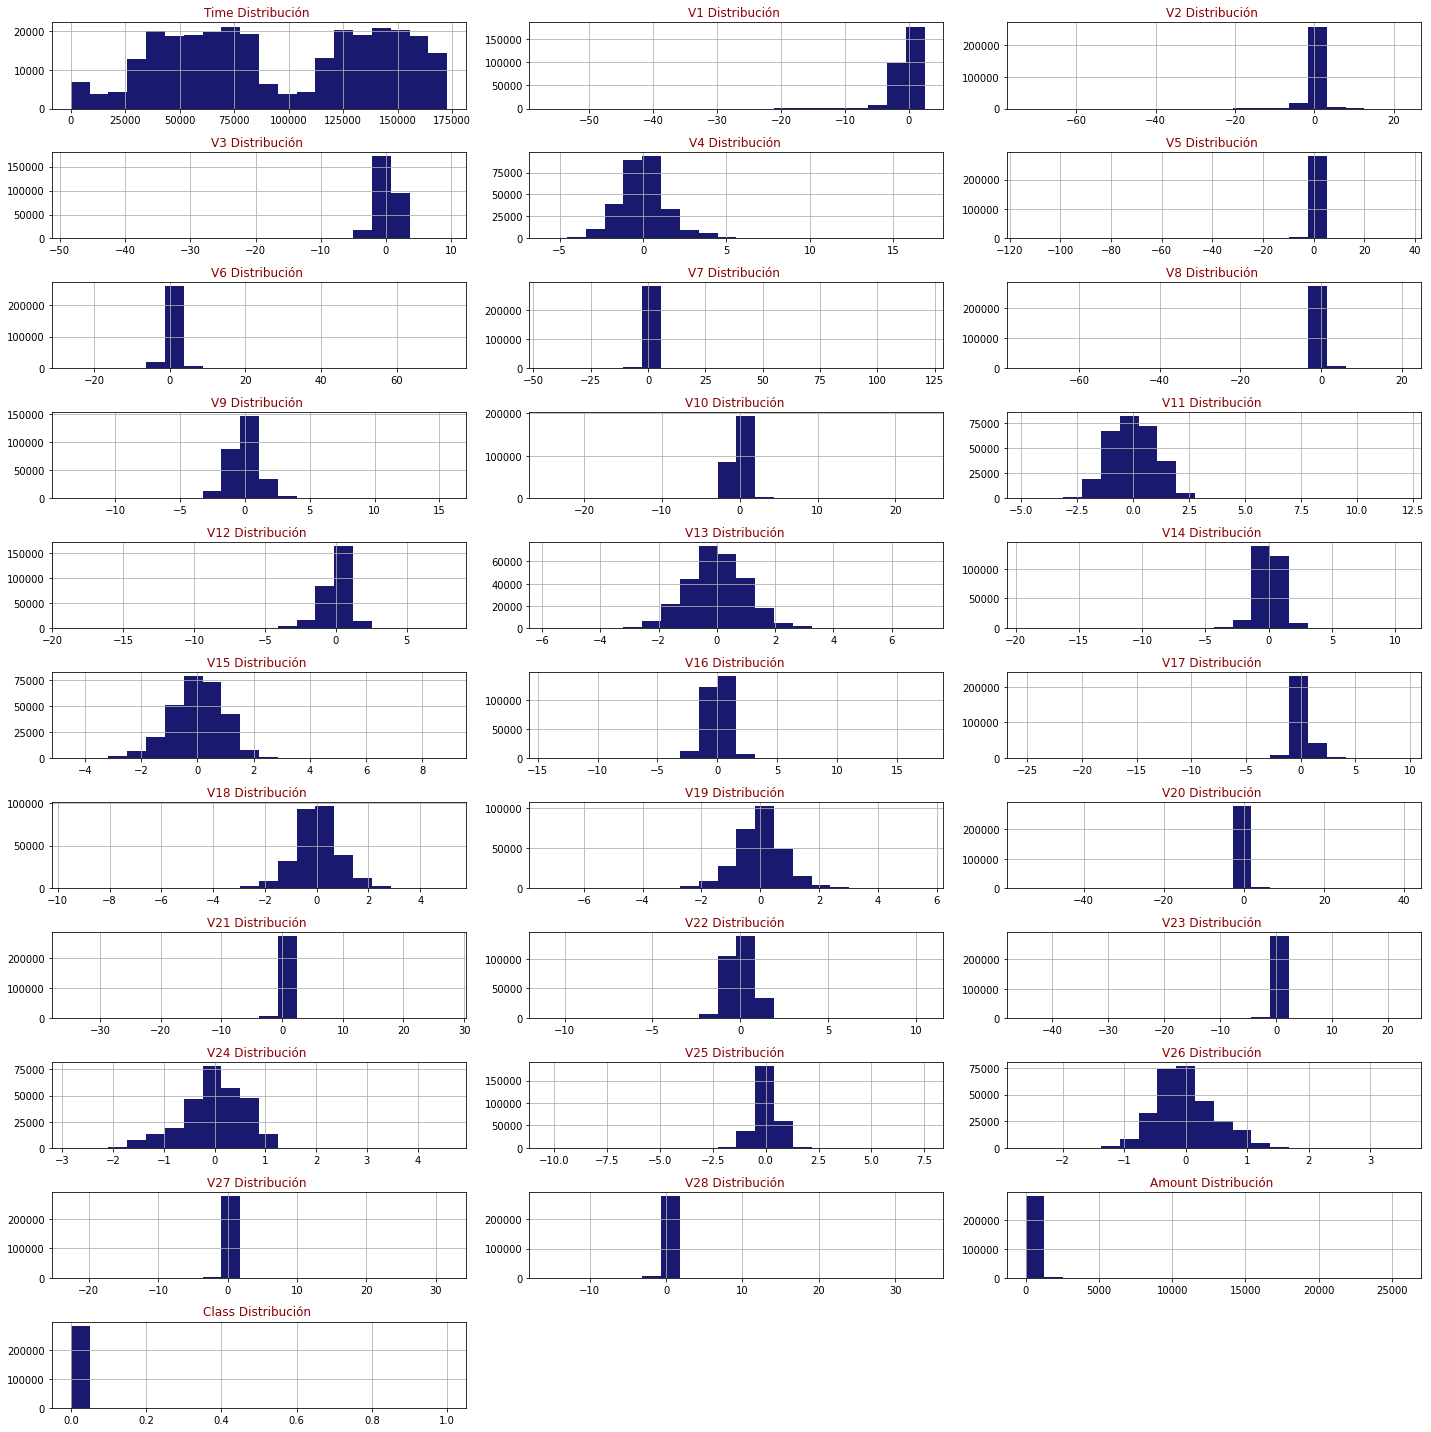

In [23]:
histogramas(df,df.columns,11,3)

Separando los datos de entrenamiento y de test

In [0]:
X = df.iloc[:,:-1]
y = df['Class']

In [0]:
#Dividiendo los dataset de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

#verificando el numero de registros por clase

In [24]:
frauds = df.loc[df['Class']==1]
non_frauds = df.loc[df['Class']==0]
print("Existen ", len(frauds), "registros como fraudes e ", len(non_frauds), " registros de datos considerados normales" )

Existen  492 registros como fraudes e  284315  registros de datos considerados normales


Como se puede observar es un sistema muy desbalanceado 

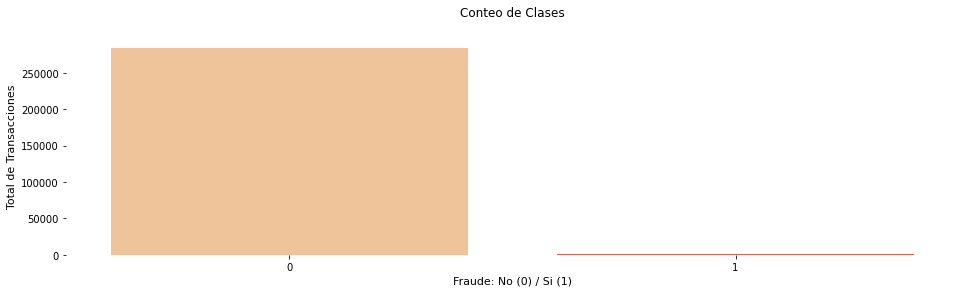

In [25]:
# Plot 
sn.countplot(df.Class, palette = "OrRd")
plt.box(False)
plt.xlabel('Fraude: No (0) / Si (1)', fontsize = 11)
plt.ylabel('Total de Transacciones', fontsize = 11)
plt.title('Conteo de Clases\n')
plt.show()

## Primera Red sin Realizas Cambios en el Dataset

In [0]:
model = tf.keras.models.Sequential()

In [27]:
model.add(tf.keras.layers.Dense(30, input_dim=30, activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='Adam',loss="binary_crossentropy",metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(X_train,y_train,epochs=5)

Epoch 1/5
6676/6676 [==============================] - 8s 1ms/step - loss: 6.6384 - accuracy: 0.9964
Epoch 2/5
6676/6676 [==============================] - 8s 1ms/step - loss: 5.5358 - accuracy: 0.9961
Epoch 3/5
6676/6676 [==============================] - 8s 1ms/step - loss: 5.9001 - accuracy: 0.9964
Epoch 4/5
6676/6676 [==============================] - 8s 1ms/step - loss: 4.4925 - accuracy: 0.9965
Epoch 5/5
6676/6676 [==============================] - 9s 1ms/step - loss: 4.7652 - accuracy: 0.9964


In [34]:
#evaluando el modelo
print("Error/Acierto en Teste: ", model.evaluate(X_test.values, y_test, verbose = 0))

Error/Acierto en Teste:  [0.9034754633903503, 0.997977614402771]


In [0]:
#Hacineod predicciones del modelo
y_predict = model.predict(X_test.values).T[0].astype(int)

In [36]:
#Reporte de clasificación
target_names = ['Class 0', 'Class 1']
print(classification_report(y_test, y_predict, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     71089
     Class 1       0.63      0.37      0.47       113

    accuracy                           1.00     71202
   macro avg       0.81      0.69      0.73     71202
weighted avg       1.00      1.00      1.00     71202



In [38]:
# Score AUC
print(roc_auc_score(y_test, y_predict))

0.6856648720406192


In [39]:
# Matriz de Confusión
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[71064    25]
 [   71    42]]


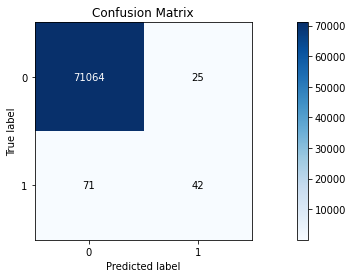

In [40]:
# Confusion Matrix Gráfica
skplt.metrics.plot_confusion_matrix(y_test, y_predict)
plt.show()

Observando la matriz de confusion se puede ver que existe una gran cantidad de predicciones correctas para una clase a diferencia de la otra y esto se debe a que el modelo recibio mas registros de la calse no fraude que de la clase fraude por que como se vio anteriormente el dataset esta muy desbalanceado, y tambien se pude ver que el valor de AUC es muy bajo.
una posible solución es balancear las clases

##Balanceamoento de clases
Para balancear se usara la técnica de Oversampling, aplicando el procedimiento estadistico llamado SMOTE que permite aumentar la cantidad de registros de las clases minoritarias

In [41]:
#verificamos el desbalanceamiento de las calses
target_count = df.Class.value_counts()
target_count

0    284315
1       492
Name: Class, dtype: int64

In [42]:
# Oversampling
from imblearn.over_sampling import SMOTE

# Seed para reproducir los datos
seed = 100

# Separando los datos en entrada (X) e salida (y)
X = df.iloc[:,:-1]
y = df['Class']

# Crear el balanceador SMOTE
smote_bal = SMOTE(random_state = seed)

# Aplica el balanceador
X_res, y_res = smote_bal.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


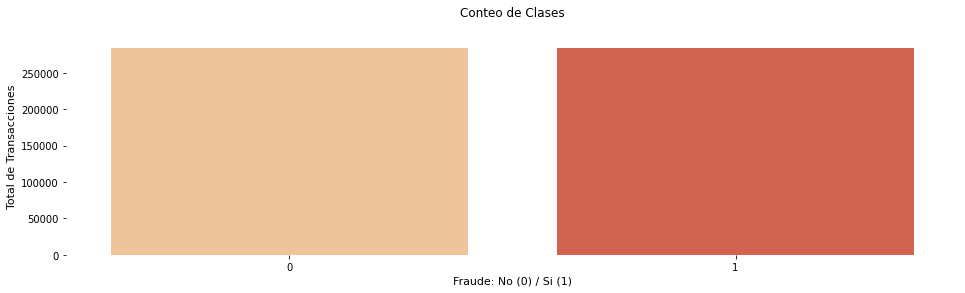

In [45]:
# Plot 
sn.countplot(y_res, palette = "OrRd")
plt.box(False)
plt.xlabel('Fraude: No (0) / Si (1)', fontsize = 11)
plt.ylabel('Total de Transacciones', fontsize = 11)
plt.title('Conteo de Clases\n')
plt.show()

In [46]:
X_res.shape

(568630, 30)

In [47]:
y_res.shape

(568630,)

In [0]:
# Dividiendo los datos en entrenaimento y teste de el nuevo dataframe balanceado 
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, random_state = 42)

###Segunda version de la red

In [50]:
model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Dense(30, input_dim=30, activation='relu'))
model2.add(tf.keras.layers.Dense(30, activation = 'relu'))
model2.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model2.compile(optimizer='Adam',loss="binary_crossentropy",metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________


In [53]:
model2.fit(X_train, y_train, epochs = 5)

Epoch 1/5
13328/13328 [==============================] - 18s 1ms/step - loss: 15.0754 - accuracy: 0.8231
Epoch 2/5
13328/13328 [==============================] - 18s 1ms/step - loss: 1.6484 - accuracy: 0.9225
Epoch 3/5
13328/13328 [==============================] - 18s 1ms/step - loss: 0.6530 - accuracy: 0.9479
Epoch 4/5
13328/13328 [==============================] - 18s 1ms/step - loss: 0.1789 - accuracy: 0.9594
Epoch 5/5
13328/13328 [==============================] - 18s 1ms/step - loss: 0.1182 - accuracy: 0.9620


In [66]:
#evaluando el modelo
print("Error/Acierto en Teste: ", model2.evaluate(X_test, y_test, verbose = 0))

Error/Acierto en Teste:  [0.11635200679302216, 0.9621196389198303]


In [0]:
#Hacineod predicciones del modelo
y_predict = model2.predict(X_test).T[0].astype(int)

In [61]:
target_names = ['Class 0', 'Class 1']
print(classification_report(y_test, y_predict, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.72      1.00      0.84     71023
     Class 1       1.00      0.61      0.76     71135

    accuracy                           0.80    142158
   macro avg       0.86      0.80      0.80    142158
weighted avg       0.86      0.80      0.80    142158



In [62]:
# Score AUC
print(roc_auc_score(y_test, y_predict))

0.8038375959003086


In [63]:
# Matriz de Confusión
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[71007    16]
 [27892 43243]]


Ahora parece como mas normal despues de haber balanceado las cargas

##Informe final del rendimiento del modelo

In [64]:
# Variables
falso_neg = 0
falso_pos = 0
incorrectos = 0
total = len(y_test)

# Loop por las predicciones y valores reales
for i in range(0, total):
    if (y_predict[i] != y_test[i]):
        incorrectos += 1
        if (y_test[i] == 1 and y_predict[i] == 0):
            falso_neg += 1
        else:
            falso_pos += 1

inprecisión = incorrectos / total

print('inprecisión:', inprecisión * 100)
print('precisión:', (1 - inprecisión) * 100)
print('Tasa de Falsos Negativos:', falso_neg / incorrectos * 100)
print('Taxa de Falsos Positivos:', falso_pos / incorrectos * 100)

inprecisión: 19.631677429339188
precisión: 80.36832257066081
Tasa de Falsos Negativos: 99.94266876881181
Taxa de Falsos Positivos: 0.057331231188189766
